<a href="https://colab.research.google.com/github/ms1901/CF_Project/blob/main/ParameterTuning/ParameterTuning_CARL_GoodReads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 5.2 MB/s 


In [ ]:
import numpy as np
import scipy.sparse as sp
import math

import tensorflow as tf
import numpy as np
import sys
from time import time
import os

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
%cd /content/drive/MyDrive/CF_end_proejct/Goodreads

/content/drive/MyDrive/CF_end_proejct/Goodreads


In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


ExtractData

In [ ]:
class Dataset(object):
    "'extract dataset from file'"

    def __init__(self, max_length, path, word_id_path):
        self.word_id_dict = self.load_word_dict(path + word_id_path)
        print("wordId_dict finished")
        
        self.userReview_dict = self.load_reviews(max_length, len(self.word_id_dict), path + "dataPreprocessingUserReviews.out")
        self.itemReview_dict = self.load_reviews(max_length, len(self.word_id_dict), path + "dataPreprocessingItemReviews.out")
        print("load reviews finished")
        
        self.num_users, self.num_items = len(self.userReview_dict), len(self.itemReview_dict)
        
        self.trainMtrx = self.load_ratingFile_as_mtrx(path + "dataPreprocessingTrainInteraction.out")
        self.valRatings = self.load_ratingFile_as_list(path + "dataPreprocessingValInteraction.out")
        self.testRatings = self.load_ratingFile_as_list(path + "dataPreprocessingTestInteraction.out")

    def load_word_dict(self, path):
        wordId_dict = {}

        with open(path, "r") as f:
            line = f.readline().replace("\n", "")
            while line != None and line != "":
                arr = line.split("\t")
                wordId_dict[arr[0]] = int(arr[1])
                line = f.readline().replace("\n", "")

        return wordId_dict

    def load_reviews(self, max_doc_length, padding_word_id, path):
        entity_review_dict = {}

        with open(path, "r") as f:
            line = f.readline().replace("\n", "")
            while line != None and line != "":
                review = []
                arr = line.split("\t")
                entity = int(arr[0])
                word_list = arr[1].split(" ")

                for i in range(len(word_list)):
                    if (word_list[i] == "" or word_list[i] == None or (not self.word_id_dict[word_list[i]] in self.word_id_dict.keys())):
                        continue
                    review.append(self.word_id_dict.get(word_list[i]))
                    if (len(review) >= max_doc_length):
                        break
                if (len(review) < max_doc_length):
                    review = self.padding_word(max_doc_length, padding_word_id, review)
                entity_review_dict[entity] = review
                line = f.readline().replace("\n", "")
        return entity_review_dict

    def padding_word(self, max_size, max_word_idx, review):
        review.extend([max_word_idx]*(max_size - len(review)))
        return review

    def load_ratingFile_as_mtrx(self, file_path):
        mtrx = sp.dok_matrix((self.num_users, self.num_items), dtype=np.float32)
        with open(file_path, "r") as f:
            line = f.readline()
            line = line.strip()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mtrx[user, item] = rating
                line = f.readline()

        return mtrx

    def load_ratingFile_as_list(self, file_path):
        rateList = []

        with open(file_path, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                rate = float(arr[2])
                rateList.append([user, item, rate])
                line = f.readline()

        return rateList

GetTest

In [ ]:
import math

def get_test_list(batch_size, test_rating, user_reviews, item_reviews):
    user_test_batchs, item_test_batchs, user_input_test_batchs, item_input_test_batchs, rating_input_test_batchs = [], [], [], [], []
    for count in range(int(math.ceil(len(test_rating) / float(batch_size)))):
        user_test, item_test, user_input_test, item_input_test, rating_input_test = [], [], [], [], []
        for idx in range(batch_size):
            index = (count * batch_size + idx)
            if (index >= len(test_rating)):
                break
            rating = test_rating[index]
            user_test.append(rating[0])
            item_test.append(rating[1])
            user_input_test.append(user_reviews.get(rating[0]))
            item_input_test.append(item_reviews.get(rating[1]))
            rating_input_test.append([rating[2]])
        user_test_batchs.append(user_test)
        item_test_batchs.append(item_test)
        user_input_test_batchs.append(user_input_test)
        item_input_test_batchs.append(item_input_test)
        rating_input_test_batchs.append(rating_input_test)
        #print count, len(item_input_test_batchs[count])
    return user_test_batchs, item_test_batchs, user_input_test_batchs, item_input_test_batchs, rating_input_test_batchs

CARL

In [ ]:
def ini_word_embed(num_words, latent_dim):
    word_embeds = np.random.rand(num_words, latent_dim)
    return word_embeds


In [ ]:
def word2vec_word_embed(num_words, latent_dim, path, word_id_dict):
    word2vect_embed_mtrx = np.zeros((num_words, latent_dim))
    with open(path, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            row_id = word_id_dict.get(arr[0])
            vect = arr[1].strip().split(" ")
            for i in range(len(vect)):
                word2vect_embed_mtrx[row_id, i] = float(vect[i])
            line = f.readline()

    return word2vect_embed_mtrx

In [ ]:
def get_train_instance(train):
    user_input, item_input, rates = [], [], []

    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        rates.append(train[u,i])
    return user_input, item_input, rates



In [ ]:
def get_train_instance_batch_change(count, batch_size, user_input, item_input, ratings, user_reviews, item_reviews):
    users_batch, items_batch, user_input_batch, item_input_batch, labels_batch = [], [], [], [], []

    for idx in range(batch_size):
        index = (count*batch_size + idx) % len(user_input)
        users_batch.append(user_input[index])
        items_batch.append(item_input[index])
        user_input_batch.append(user_reviews.get(user_input[index]))
        item_input_batch.append(item_reviews.get(item_input[index]))
        labels_batch.append([ratings[index]])

    return users_batch, items_batch, user_input_batch, item_input_batch, labels_batch

In [ ]:
#review.py
def  cnn_model_average(filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix):
    #convolution layer
    convU = tf.nn.conv2d(user_reviews_representation_expnd, W_u, strides=[1, 1, word_latent_dim, 1], padding='SAME')
    convI = tf.nn.conv2d(item_reviews_representation_expnd, W_i, strides=[1, 1, word_latent_dim, 1], padding='SAME')

    hU = tf.nn.relu(tf.squeeze(convU, 2))
    hI = tf.nn.relu(tf.squeeze(convI, 2))

    # attentive layer
    sec_dim = int(hU.get_shape()[1])
    tmphU = tf.reshape(hU, [-1, filters])
    hU_mul_rand = tf.reshape(tf.matmul(tmphU, rand_matrix), [-1, sec_dim, filters])
    f = tf.matmul(hU_mul_rand, hI, transpose_b=True)
    f = tf.expand_dims(f, -1)
    att1 = tf.tanh(f)

    pool_user = tf.reduce_mean(att1, 2)
    pool_item = tf.reduce_mean(att1, 1)

    user_flat = tf.squeeze(pool_user, -1)
    item_flat = tf.squeeze(pool_item, -1)

    weight_user = tf.nn.softmax(user_flat)
    weight_item = tf.nn.softmax(item_flat)

    weight_user_exp = tf.expand_dims(weight_user, -1)
    weight_item_exp = tf.expand_dims(weight_item, -1)

    hU = tf.expand_dims(hU * weight_user_exp, -1)
    hI = tf.expand_dims(hI * weight_item_exp, -1)

    #abstracting layer
    hU_1 = tf.nn.relu(tf.nn.conv2d(hU, W_u_1, strides=[1, 1, 1, 1], padding='VALID'))
    hI_1 = tf.nn.relu(tf.nn.conv2d(hI, W_i_1, strides=[1, 1, 1, 1], padding='VALID'))

    sec_dim = hU_1.get_shape()[1]

    oU = tf.nn.avg_pool(hU_1, ksize=[1, sec_dim, 1, 1], strides=[1, 1, 1, 1],
        padding='VALID')
    oI = tf.nn.avg_pool(hI_1, ksize=[1, sec_dim, 1, 1], strides=[1, 1, 1, 1],
        padding='VALID')

    att_user = tf.squeeze(oU)
    att_item = tf.squeeze(oI)
    #print "attention", att_user.get_shape(), att_item.get_shape()

    return att_user, att_item

In [ ]:
def eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_batch, item_batch, user_input_batch, item_input_batch, rate_tests, rmses, maes):
    print(sess)
    print("user batch. "+str(user_batch))
    print("item batch "+str(item_batch))
    print("user_input_batch. "+str(user_input_batch))
    print("item_input_batch "+str( item_input_batch))

    print("before session run")
    predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
    print("after session run")
    #print(predicts)
    row, col = predicts.shape
    for r in range(row):
        rmses.append(pow((predicts[r, 0] - rate_tests[r][0]), 2))
        maes.append(abs((predicts[r, 0] - rate_tests[r][0])))
    print(rmses)
    return rmses, maes


In [ ]:
#combination of interaction.py and review.py
def train_model():
    mae_list=[]
    mse_list=[]
    tf.compat.v1.disable_eager_execution()
    #I and R-----
    users = tf.compat.v1.placeholder(tf.int32, shape=[None])
    items = tf.compat.v1.placeholder(tf.int32, shape=[None])
    users_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    items_inputs = tf.compat.v1.placeholder(tf.int32, shape=[None, max_doc_length])
    ratings = tf.compat.v1.placeholder(tf.float32, shape=[None, 1])
    
    #R-----
    dropout_rate = tf.compat.v1.placeholder(tf.float32)
    
    #I-----
    user_entity_embedding = tf.Variable(tf.random.normal([num_users, latent_dim], mean=0, stddev=0.02), name="user_entity_embeddings")
    item_entity_embedding = tf.Variable(tf.random.normal([num_items, latent_dim], mean=0, stddev=0.02), name="item_entity_embeddings")
    user_entity_embeds = tf.nn.embedding_lookup(user_entity_embedding, users)
    item_entity_embeds = tf.nn.embedding_lookup(item_entity_embedding, items)
    
    #R-----
    user_bias = tf.Variable(tf.random.normal([num_users, 1], mean=0, stddev=0.02), name="user_bias")
    item_bias = tf.Variable(tf.random.normal([num_items, 1], mean=0, stddev=0.02), name="item_bias")
    user_bs = tf.nn.embedding_lookup(user_bias, users)
    item_bs = tf.nn.embedding_lookup(item_bias, items)
    
    text_embedding = tf.Variable(word_embedding_mtrx, dtype=tf.float32, name="review_text_embeds")
    padding_embedding = tf.Variable(np.zeros([1, word_latent_dim]), dtype=tf.float32)
    text_mask = tf.constant([1.0] * text_embedding.get_shape()[0] + [0.0])
    word_embeddings = tf.concat([text_embedding, padding_embedding], 0)
    word_embeddings = word_embeddings * tf.expand_dims(text_mask, -1)
    user_reviews_representation = tf.nn.embedding_lookup(word_embeddings, users_inputs)
    user_reviews_representation_expnd = tf.expand_dims(user_reviews_representation, -1)
    item_reviews_representation = tf.nn.embedding_lookup(word_embeddings, items_inputs)
    item_reviews_representation_expnd = tf.expand_dims(item_reviews_representation, -1)
    
    # CNN layers
    W_u = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_u")
    W_i = tf.Variable(tf.random.truncated_normal([window_size, word_latent_dim, 1, num_filters], stddev=0.3), name="review_W_i")
    W_u_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_u_1")
    W_i_1 = tf.Variable(tf.random.truncated_normal([window_size, num_filters, 1, num_filters], stddev=0.3), name="review_W_i_1")
    # b = tf.Variable(tf.constant(0.1, shape=[self.num_filters]))
    rand_matrix = tf.Variable(tf.random.truncated_normal([num_filters, num_filters], stddev=0.3), name="review_rand_matrix")

    user_embeds, item_embeds = cnn_model_average(num_filters, user_reviews_representation_expnd, item_reviews_representation_expnd, W_u, W_i, W_u_1, W_i_1, rand_matrix)
    
    #shared MLP layer
    W_mlp = tf.Variable(tf.random.normal([num_filters, latent_dim], mean=0, stddev=0.02), name="review_W_mlp")
    W_mlp = tf.nn.dropout(W_mlp, dropout_rate)
    b_mlp = tf.Variable(tf.constant(0.1, shape=[latent_dim]), name="review_b_mlp")

    user_embeds = tf.nn.relu(tf.matmul(user_embeds, W_mlp) + b_mlp)
    item_embeds = tf.nn.relu(tf.matmul(item_embeds, W_mlp) + b_mlp)

    embeds_sum = tf.concat([tf.multiply(user_embeds, item_embeds), user_embeds, item_embeds], 1, name="concat_embed")
    #I
    entity_embeds_sum = tf.concat([tf.multiply(user_entity_embeds, item_entity_embeds), user_entity_embeds, item_entity_embeds],1)

    #FM layer
    #R---
    w_0 = tf.Variable(tf.zeros(1), name="review_w_0")
    w_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim * 3], stddev=0.3), name="review_w_1")
    v = tf.Variable(tf.random.truncated_normal([latent_dim * 3, latent_dim * 3], stddev=0.3), name="review_v")
    
    #I---
    w_entity_0 = tf.Variable(tf.zeros(1), name="entity_w_0")
    w_entity_1 = tf.Variable(tf.random.truncated_normal([1, latent_dim*3], stddev=0.3), name="entity_w_1")
    v_entity = tf.Variable(tf.random.truncated_normal([latent_dim*3, v_dim], stddev=0.3), name="entity_v")
    
    #I---
    J_e_1 = w_entity_0 + tf.matmul(entity_embeds_sum, w_entity_1, transpose_b=True)
    #R---
    J_1 = w_0 + tf.matmul(embeds_sum, w_1, transpose_b=True)
    
    #I---
    entity_embeds_sum_1 = tf.expand_dims(entity_embeds_sum, -1)
    entity_embeds_sum_2 = tf.expand_dims(entity_embeds_sum, 1)
    #R---
    embeds_sum_1 = tf.expand_dims(embeds_sum, -1)
    embeds_sum_2 = tf.expand_dims(embeds_sum, 1)
    
    #I---
    J_e_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True)),2), 1, keepdims=True)
    #J_e_3 = tf.trace(tf.multiply(tf.matmul(entity_embeds_sum_1, entity_embeds_sum_2), tf.matmul(v_entity, v_entity, transpose_b=True))) 
    
    #R---
    J_2 = tf.reduce_sum(tf.reduce_sum(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)),2), 1, keepdims=True)
    #J_3 = tf.trace(tf.multiply(tf.matmul(embeds_sum_1, embeds_sum_2), tf.matmul(v, v, transpose_b=True)))
    #R---
    J_total = (J_1 + 0.5 * (J_2))
    
    #I---
    J_e_total = (J_e_1 + 0.5 * (J_e_2))
    
    
    numerator = J_total + J_e_total
    predict_rating = tf.divide(J_total, numerator) * J_total + tf.divide(J_e_total,numerator) * J_e_total + user_bs + item_bs
    loss = tf.reduce_mean(tf.math.squared_difference(predict_rating, ratings))
    loss += lambda_1 * (tf.nn.l2_loss(W_i_1) + tf.nn.l2_loss(W_u_1) + tf.nn.l2_loss(user_entity_embedding) + tf.nn.l2_loss(item_entity_embedding) + tf.nn.l2_loss(W_u) + tf.nn.l2_loss(W_i) + tf.nn.l2_loss(v) + tf.nn.l2_loss(v_entity) + tf.nn.l2_loss(rand_matrix) + tf.nn.l2_loss(user_bs) + tf.nn.l2_loss(item_bs))
    
    train_step = tf.compat.v1.train.RMSPropOptimizer(learning_rate).minimize(loss)
    saver = tf.compat.v1.train.Saver()
    
    init = tf.compat.v1.global_variables_initializer()
    with tf.compat.v1.Session() as sess:
        sess.run(init)

        for e in range(epochs):
            t = time()
            loss_total = 0.0
            count = 0.0
            
            for i in range(int(math.ceil(len(user_input) / float(batch_size)))):
                user_batch, item_batch, user_input_batch, item_input_batch, rates_batch = get_train_instance_batch_change(i, batch_size,user_input, item_input, rateings, user_reviews,item_reviews)
                _, loss_val, words = sess.run([train_step, loss, word_embeddings], feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, ratings: rates_batch, dropout_rate:drop_out})
                loss_total += loss_val
                count += 1.0

            t1 = time()            
            #LOOK FROM HERE 
            val_mses, val_maes = [], []
            for i in range(len(user_input_val)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_vals[i], item_vals[i], user_input_val[i], item_input_val[i], rating_input_val[i], val_mses, val_maes)
                #predicts = sess.run(predict_rating, feed_dict={users: user_batch, items: item_batch, users_inputs: user_input_batch, items_inputs: item_input_batch, dropout_rate:1.0})
                predicts = sess.run(predict_rating, feed_dict={users: user_vals[i], items: item_vals[i], users_inputs: user_input_val[i], items_inputs: item_input_val[i], ratings: rating_input_val[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts.shape
                for r in range(row):
                    val_mses.append(pow((predicts[r, 0] - rating_input_val[i][r][0]), 2))
                    val_maes.append(abs((predicts[r, 0] - rating_input_val[i][r][0])))
            val_mse = np.array(val_mses).mean()            
            t2 = time()            
            mses, maes = [], []
            for i in range(len(user_input_test)):
                #eval_model(users, items, users_inputs, items_inputs, dropout_rate, predict_rating, sess, user_tests[i], item_tests[i], user_input_test[i], item_input_test[i], rating_input_test[i], mses, maes)
                predicts_test = sess.run(predict_rating, feed_dict={users: user_tests[i], items: item_tests[i], users_inputs: user_input_test[i], items_inputs: item_input_test[i], ratings: rating_input_test[i], dropout_rate: drop_out})
                #print(predicts)
                row, col = predicts_test.shape
                for r in range(row):
                    mses.append(pow((predicts_test[r, 0] - rating_input_test[i][r][0]), 2))
                    maes.append(abs((predicts_test[r, 0] - rating_input_test[i][r][0])))
                    
            mse = np.array(mses).mean()
            mae = np.array(maes).mean()
            t3 = time()
            mae_list.append(mae)
            mse_list.append(mse)
            print("epoch%d train time: %.3fs test time: %.3f  loss = %.3f val_mse = %.3f mse = %.3f mae = %.3f"%(e, (t1 - t), (t3 - t2), loss_total/count, val_mse, mse, mae))
        
        avg_mae=sum(mae_list) / len(mae_list)
        avg_mse=sum(mse_list)/len(mse_list)
        avg_mae_list.append(avg_mae)
        avg_mse_list.append(avg_mse)
        print("MAE "+str(avg_mae))
        print("MSE "+str(avg_mse))

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.05 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 180
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 5.114s
506 2581
15
shape (19930, 300)
18880 18880 18880
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch0 train time: 17.107s test time: 0.626  loss = 192.471 val_mse = 1.566 mse = 1.501 mae = 0.887
epoch1 train time: 4.740s test time: 0.541  loss = 121.049 val_mse = 1.570 mse = 1.508 mae = 0.878
epoch2 train time: 4.744s test time: 0.542  loss = 59.462 val_mse = 1.564 mse = 1.503 mae = 0.877
epoch3 train time: 4.751s test time: 0.538  loss = 25.787 val_mse = 1.556 mse = 1.498 mae = 0.876
epoch4 train time: 4.853s test time: 0.538  loss = 9.666 val_mse = 1.546 mse = 1.490 mae = 0.874
epoch5 train time: 4.785s test time: 0.544  loss = 3.384 val_mse = 1.536 mse = 1.483 mae = 0.872
epoch6 train time: 4.794s test time: 0.545  loss = 1.710 val_mse = 1.525 mse = 1.475 mae = 0.871
epoch7 train time: 4.768s test time: 0.540  loss = 1.476 val_mse = 1.513 mse = 1.467 

Varying EPOCHS

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 60
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()

    epochs = 120
    #train & eval model
    train_model()

    epochs = 180
    #train & eval model
    train_model()

    epochs = 240
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 1.538s
506 2581
15
shape (19930, 300)
18880 18880 18880
epoch0 train time: 5.118s test time: 0.539  loss = 44.523 val_mse = 1.579 mse = 1.514 mae = 0.883
epoch1 train time: 4.714s test time: 0.541  loss = 30.372 val_mse = 1.576 mse = 1.515 mae = 0.882
epoch2 train time: 4.741s test time: 0.546  loss = 16.172 val_mse = 1.552 mse = 1.497 mae = 0.876
epoch3 train time: 4.734s test time: 0.546  loss = 7.889 val_mse = 1.528 mse = 1.480 mae = 0.871
epoch4 train time: 4.753s test time: 0.548  loss = 3.721 val_mse = 1.504 mse = 1.463 mae = 0.866
epoch5 train time: 4.780s test time: 0.545  loss = 1.957 val_mse = 1.481 mse = 1.447 mae = 0.862
epoch6 train time: 4.790s test time: 0.542  loss = 1.394 val_mse = 1.457 mse = 1.431 mae = 0.859
epoch7 train time: 4.764s test time: 0.551  loss = 1.276 val_mse = 1.434 mse = 1.416 mae = 0.856
epoch8 train time: 4.794s test time: 0.551  loss = 1.233 val_mse = 1.410 mse = 1.401 mae = 0.854
epoch9 train 

avg mae over epochs = [60, 120, 180, 240]: [0.845240419804884, 0.8374417539447163, 0.8364452190112996, 0.8339613501772636]
avg mse over epochs = [60, 120, 180, 240]: [1.3344836261132609, 1.3195535680625576, 1.309650268364305, 1.3063634430115583]


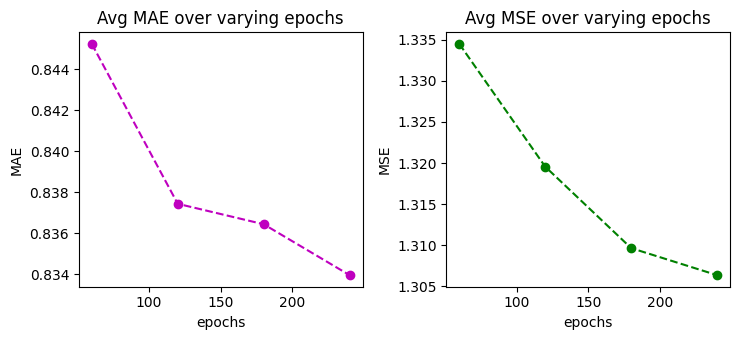

minimum avg mae over epochs = 0.8339613501772636 at epoch = 240 and mse = 1.3063634430115583
minimum avg mse over epochs = 1.3063634430115583 at epoch = 240 and mae = 0.8339613501772636


In [ ]:
avg_mae_list = [0.845240419804884,0.8374417539447163,0.8364452190112996,0.8339613501772636]
avg_mse_list = [1.3344836261132609,1.3195535680625576,1.309650268364305,1.3063634430115583]
epochs_list = [60, 120, 180, 240]
print(f'avg mae over epochs = [60, 120, 180, 240]: {avg_mae_list}')
print(f'avg mse over epochs = [60, 120, 180, 240]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(epochs_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying epochs')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('MAE')

axes[1].plot(epochs_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying epochs')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over epochs = {min} at epoch = {epochs_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over epochs = {min} at epoch = {epochs_list[min_index]} and mae = {avg_mae_list[min_index]}')

epochs = 240

Varying LAMBDA

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_list = [0.001, 0.005, 0.01, 0.05]
    lambda_1 = 0.001 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 240
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()

    lambda_1 = 0.005
    #train & eval model
    train_model()

    lambda_1 = 0.01
    #train & eval model
    train_model()

    lambda_1 = 0.05
    #train & eval model
    train_model()



wordId_dict finished
load reviews finished
load data: 3.139s
506 2581
15
shape (19930, 300)
18880 18880 18880
epoch0 train time: 5.331s test time: 0.728  loss = 8.513 val_mse = 1.588 mse = 1.521 mae = 0.884
epoch1 train time: 5.548s test time: 0.682  loss = 4.655 val_mse = 1.566 mse = 1.509 mae = 0.881
epoch2 train time: 5.396s test time: 0.551  loss = 3.166 val_mse = 1.522 mse = 1.478 mae = 0.872
epoch3 train time: 4.878s test time: 0.556  loss = 2.033 val_mse = 1.474 mse = 1.447 mae = 0.864
epoch4 train time: 4.886s test time: 0.549  loss = 1.409 val_mse = 1.431 mse = 1.422 mae = 0.858
epoch5 train time: 4.885s test time: 0.550  loss = 1.104 val_mse = 1.393 mse = 1.403 mae = 0.854
epoch6 train time: 4.908s test time: 0.550  loss = 0.974 val_mse = 1.359 mse = 1.385 mae = 0.851
epoch7 train time: 4.911s test time: 0.557  loss = 0.923 val_mse = 1.323 mse = 1.365 mae = 0.848
epoch8 train time: 4.897s test time: 0.549  loss = 0.896 val_mse = 1.286 mse = 1.342 mae = 0.846
epoch9 train tim

avg mae over lambda = [0.001, 0.005, 0.01, 0.05]: [0.9561675719966913, 0.833382876876455, 0.8332786701043388, 0.8397565477635661]
avg mse over lambda = [0.001, 0.005, 0.01, 0.05]: [65.55600156321124, 1.3009332724232503, 1.3050463728962762, 1.3220048676510137]


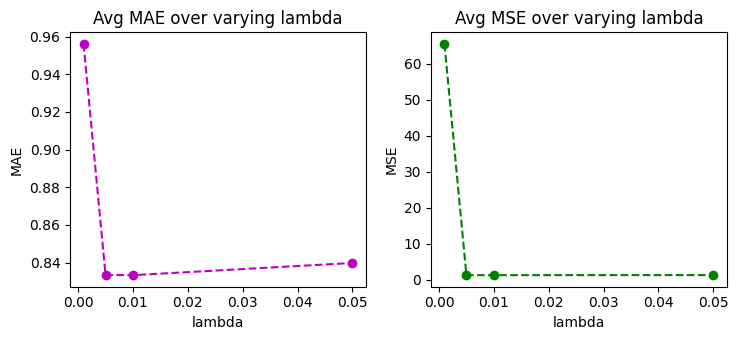

minimum avg mae over lambda = 0.8332786701043388 at lambda = 0.01 and mse = 1.3050463728962762
minimum avg mse over lambda = 1.3009332724232503 at lambda = 0.005 and mae = 0.833382876876455


In [ ]:
avg_mae_list = [0.9561675719966913,0.833382876876455,0.8332786701043388,0.8397565477635661]
avg_mse_list = [65.55600156321124,1.3009332724232503,1.3050463728962762,1.3220048676510137]
lambda_list = [0.001, 0.005, 0.01, 0.05]
print(f'avg mae over lambda = [0.001, 0.005, 0.01, 0.05]: {avg_mae_list}')
print(f'avg mse over lambda = [0.001, 0.005, 0.01, 0.05]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(lambda_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying lambda')
axes[0].set_xlabel('lambda')
axes[0].set_ylabel('MAE')

axes[1].plot(lambda_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying lambda')
axes[1].set_xlabel('lambda')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over lambda = {min} at lambda = {lambda_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over lambda = {min} at lambda = {lambda_list[min_index]} and mae = {avg_mae_list[min_index]}')

lambda = 0.01

Varying latent dimensions

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim_list = [15, 25, 50, 100, 150, 200, 300]
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.8
    batch_size = 200
    epochs = 240
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    # #train & eval model
    # train_model()

    # latent_dim = 25
    # #train & eval model
    # train_model()

    # latent_dim = 50
    # #train & eval model
    # train_model()

    # latent_dim = 100
    # #train & eval model
    # train_model()

    # latent_dim = 150
    # #train & eval model
    # train_model()

    # latent_dim = 200
    # #train & eval model
    # train_model()

    latent_dim = 300
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 4.245s
506 2581
15
shape (19930, 300)
18880 18880 18880
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch0 train time: 25.925s test time: 1.336  loss = 1000.541 val_mse = 1.653 mse = 1.585 mae = 0.910
epoch1 train time: 12.905s test time: 1.259  loss = 294.003 val_mse = 3.526 mse = 3.451 mae = 1.421
epoch2 train time: 13.014s test time: 1.270  loss = 214.555 val_mse = 1.446 mse = 1.439 mae = 0.897
epoch3 train time: 13.127s test time: 1.281  loss = 151.437 val_mse = 2.153 mse = 2.103 mae = 1.030
epoch4 train time: 13.230s test time: 1.293  loss = 103.477 val_mse = 1.489 mse = 1.504 mae = 1.005
epoch5 train time: 13.191s test time: 1.273  loss = 75.018 val_mse = 3.390 mse = 3.302 mae = 1.392
epoch6 train time: 13.104s test time: 1.270  loss = 49.841 val_mse = 1.469 mse = 1.465 mae = 0.866
epoch7 train time: 13.133s test time: 1.270  loss = 32.212 val_mse = 1.5

avg mae over latent dimensions = [15, 25, 50, 100, 150, 200, 300]: [0.8336581640065943, 0.8367746955439975, 0.8384994930729953, 0.8393451425843893, 0.8401304164530726, 0.8422882341843104, 0.8492282073119388]
avg mse over latent dimensions = [15, 25, 50, 100, 150, 200, 300]: [1.3068985484525304, 1.30281279577794, 1.304984137262511, 1.3077363295802589, 1.3097868493808178, 1.3139178403260174, 1.3360866416687927]


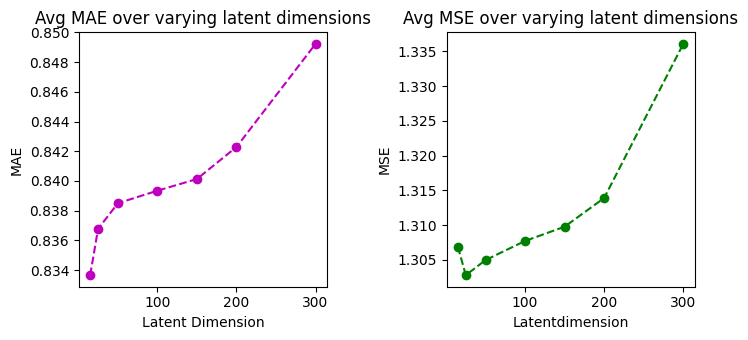

minimum avg mae over latent dimensions = 0.8336581640065943 at latent dimension = 15 and mse = 1.3068985484525304
minimum avg mse over latent dimensions = 1.30281279577794 at laten dimension = 25 and mae = 0.8367746955439975


In [ ]:
avg_mae_list = [0.8336581640065943,0.8367746955439975,0.8384994930729953,0.8393451425843893,0.8401304164530726,0.8422882341843104,0.8492282073119388]
avg_mse_list = [1.3068985484525304,1.30281279577794,1.304984137262511,1.3077363295802589,1.3097868493808178,1.3139178403260174,1.3360866416687927]
latent_dim_list = [15, 25, 50, 100, 150, 200, 300]
print(f'avg mae over latent dimensions = [15, 25, 50, 100, 150, 200, 300]: {avg_mae_list}')
print(f'avg mse over latent dimensions = [15, 25, 50, 100, 150, 200, 300]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(latent_dim_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying latent dimensions')
axes[0].set_xlabel('Latent Dimension')
axes[0].set_ylabel('MAE')

axes[1].plot(latent_dim_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying latent dimensions')
axes[1].set_xlabel('Latentdimension')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over latent dimensions = {min} at latent dimension = {latent_dim_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over latent dimensions = {min} at laten dimension = {latent_dim_list[min_index]} and mae = {avg_mae_list[min_index]}')

latent dimensions = 15

Varying dropout rates

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 25
    max_doc_length = 300
    num_filters = 50
    window_size = 3
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    drop_out = 0.2
    batch_size = 200
    epochs = 180
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()

    drop_out = 0.3
    #train & eval model
    train_model()

    drop_out = 0.4
    #train & eval model
    train_model()
    
    drop_out = 0.5
    #train & eval model
    train_model()

    drop_out = 0.6
    #train & eval model
    train_model()

    drop_out = 0.7
    #train & eval model
    train_model()

    drop_out = 0.8
    #train & eval model
    train_model()

    drop_out = 0.9
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 1.448s
506 2581
25
shape (19930, 300)
18880 18880 18880
epoch0 train time: 4.964s test time: 0.528  loss = 42.522 val_mse = 1.636 mse = 1.561 mae = 0.906
epoch1 train time: 4.623s test time: 0.530  loss = 32.014 val_mse = 1.618 mse = 1.551 mae = 0.903
epoch2 train time: 4.646s test time: 0.538  loss = 17.242 val_mse = 1.591 mse = 1.532 mae = 0.894
epoch3 train time: 4.670s test time: 0.536  loss = 8.598 val_mse = 1.563 mse = 1.512 mae = 0.885
epoch4 train time: 4.696s test time: 0.540  loss = 4.204 val_mse = 1.534 mse = 1.491 mae = 0.875
epoch5 train time: 4.714s test time: 0.543  loss = 2.300 val_mse = 1.505 mse = 1.470 mae = 0.865
epoch6 train time: 4.731s test time: 0.548  loss = 1.649 val_mse = 1.473 mse = 1.448 mae = 0.858
epoch7 train time: 4.757s test time: 0.545  loss = 1.471 val_mse = 1.434 mse = 1.419 mae = 0.852
epoch8 train time: 4.787s test time: 0.545  loss = 1.380 val_mse = 1.399 mse = 1.395 mae = 0.849
epoch9 train 

avg mae over drop out rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: [0.8381531545991346, 0.8383916606721673, 0.838968696967958, 0.8388697302821002, 0.8393858781233233, 0.8363583598807807, 0.8387940185962007, 0.8371213764721958]
avg mse over drop out rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: [1.3133382432145548, 1.3119380319514957, 1.307635431930038, 1.3123322760781038, 1.3068397265143166, 1.3114134781678832, 1.3108765653804264, 1.3116436500942947]


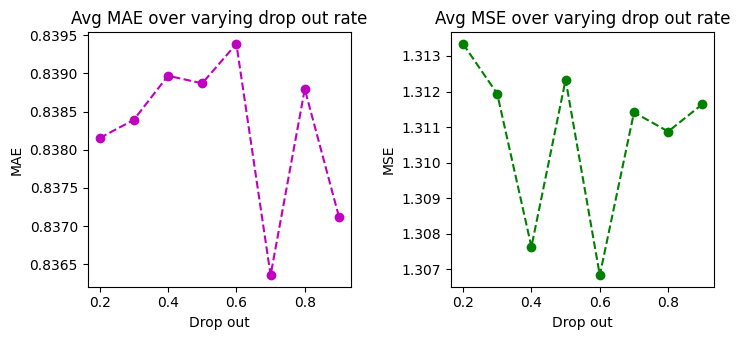

minimum avg mae over drop out rates = 0.8363583598807807 at drop out rate = 0.7 and mse = 1.3114134781678832
minimum avg mse over drop out rates = 1.3068397265143166 at drop out rate = 0.6 and mae = 0.8393858781233233


In [ ]:
avg_mae_list = [0.8381531545991346,0.8383916606721673,0.838968696967958,0.8388697302821002,0.8393858781233233,0.8363583598807807,0.8387940185962007,0.8371213764721958]
avg_mse_list = [1.3133382432145548,1.3119380319514957,1.307635431930038,1.3123322760781038,1.3068397265143166,1.3114134781678832,1.3108765653804264,1.3116436500942947]
drop_out_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
print(f'avg mae over drop out rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: {avg_mae_list}')
print(f'avg mse over drop out rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(drop_out_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying drop out rate')
axes[0].set_xlabel('Drop out')
axes[0].set_ylabel('MAE')

axes[1].plot(drop_out_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying drop out rate')
axes[1].set_xlabel('Drop out')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over drop out rates = {min} at drop out rate = {drop_out_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over drop out rates = {min} at drop out rate = {drop_out_list[min_index]} and mae = {avg_mae_list[min_index]}')

drop out rate = 0.6

Varying sliding window

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size_list = [2, 3, 5, 10]
    window_size = 2
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.6
    batch_size = 200
    epochs = 180
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()
    
    window_size = 3
    #train & eval model
    train_model()

    window_size = 5
    #train & eval model
    train_model()

    window_size = 10
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 2.773s
506 2581
15
shape (19930, 300)
18880 18880 18880
epoch0 train time: 29.008s test time: 0.593  loss = 30.842 val_mse = 1.586 mse = 1.522 mae = 0.885
epoch1 train time: 4.504s test time: 0.484  loss = 21.264 val_mse = 1.572 mse = 1.512 mae = 0.881
epoch2 train time: 4.503s test time: 0.483  loss = 11.531 val_mse = 1.550 mse = 1.496 mae = 0.876
epoch3 train time: 4.514s test time: 0.490  loss = 5.857 val_mse = 1.529 mse = 1.480 mae = 0.871
epoch4 train time: 4.528s test time: 0.490  loss = 2.996 val_mse = 1.507 mse = 1.464 mae = 0.867
epoch5 train time: 4.545s test time: 0.497  loss = 1.774 val_mse = 1.484 mse = 1.448 mae = 0.863
epoch6 train time: 4.542s test time: 0.491  loss = 1.373 val_mse = 1.461 mse = 1.433 mae = 0.860
epoch7 train time: 4.549s test time: 0.492  loss = 1.279 val_mse = 1.439 mse = 1.417 mae = 0.858
epoch8 train time: 4.539s test time: 0.489  loss = 1.238 val_mse = 1.416 mse = 1.403 mae = 0.856
epoch9 train

avg mae over window size = [2, 3, 5, 10]: [0.8371292235590698, 0.8353306033873166, 0.837623648531389, 0.8539131697407135]
avg mse over window size = [2, 3, 5, 10]: [1.3096931666826137, 1.3127908019585943, 1.3066071470052691, 1.3919414789888864]


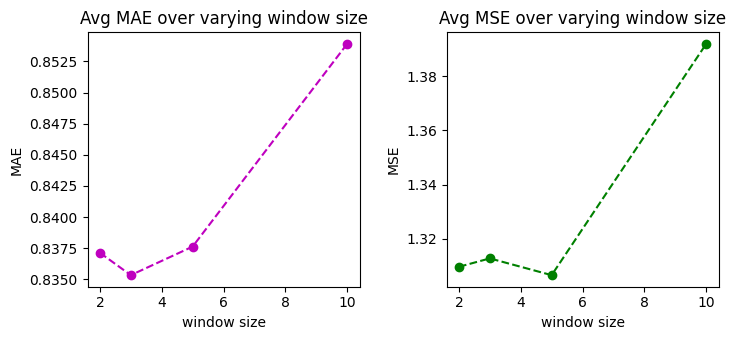

minimum avg mae over window sizes = 0.8353306033873166 at window size = 3 and mse = 1.3127908019585943
minimum avg mse over window sizes = 1.3066071470052691 at window size = 5 and mae = 0.837623648531389


In [ ]:
avg_mae_list = [0.8371292235590698,0.8353306033873166,0.837623648531389,0.8539131697407135]
avg_mse_list = [1.3096931666826137,1.3127908019585943,1.3066071470052691,1.3919414789888864]
window_size_list = [2, 3, 5, 10]
print(f'avg mae over window size = [2, 3, 5, 10]: {avg_mae_list}')
print(f'avg mse over window size = [2, 3, 5, 10]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(window_size_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying window size')
axes[0].set_xlabel('window size')
axes[0].set_ylabel('MAE')

axes[1].plot(window_size_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying window size')
axes[1].set_xlabel('window size')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over window sizes = {min} at window size = {window_size_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over window sizes = {min} at window size = {window_size_list[min_index]} and mae = {avg_mae_list[min_index]}')

sliding window size = 5

Varying batch size

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 5
    v_dim = 50
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.4
    batch_size_list = [100, 200, 250, 300, 500]
    batch_size = 100
    epochs = 120
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    # train_model()
    
    # batch_size = 200
    # #train & eval model
    # train_model()

    # batch_size = 250
    # #train & eval model
    # train_model()

    # batch_size = 300
    # #train & eval model
    # train_model()

    batch_size = 500
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 3.652s
506 2581
15
shape (19930, 300)
18880 18880 18880
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch0 train time: 21.082s test time: 0.863  loss = 74.465 val_mse = 6.420 mse = 6.477 mae = 2.357
epoch1 train time: 5.793s test time: 0.731  loss = 65.597 val_mse = 1.563 mse = 1.499 mae = 0.903
epoch2 train time: 5.804s test time: 0.732  loss = 60.813 val_mse = 1.569 mse = 1.504 mae = 0.884
epoch3 train time: 5.870s test time: 0.734  loss = 51.605 val_mse = 1.551 mse = 1.492 mae = 0.879
epoch4 train time: 5.884s test time: 0.738  loss = 40.422 val_mse = 1.529 mse = 1.476 mae = 0.875
epoch5 train time: 6.077s test time: 0.740  loss = 30.952 val_mse = 1.506 mse = 1.460 mae = 0.873
epoch6 train time: 5.947s test time: 0.741  loss = 23.342 val_mse = 1.484 mse = 1.444 mae = 0.871
epoch7 train time: 5.979s test time: 0.747  loss = 17.321 val_mse = 1.462 mse = 1.42

avg mae over batch size = [100, 200, 250, 300, 500]: [0.8694882972184632, 0.8395612463259544, 0.840025205422845, 0.8466306726586323, 0.8512053771461526]
avg mse over batch size = [100, 200, 250, 300, 500]: [1.3378884361893557, 1.3199179432485686, 1.3143156646765504, 1.3098875162285837, 1.3595100656998025]


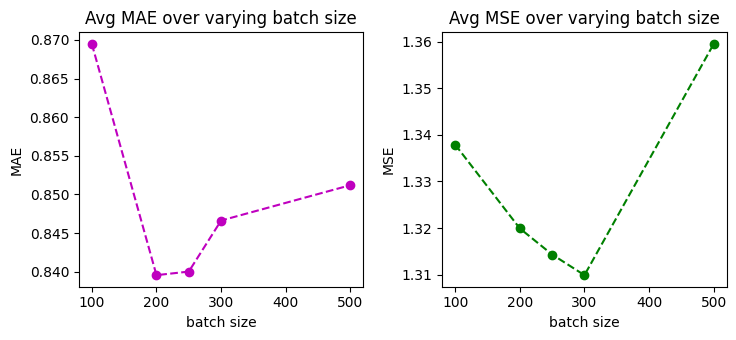

minimum avg mae over batch sizes = 0.8395612463259544 at batch size = 200 and mse = 1.3199179432485686
minimum avg mse over batch sizes = 1.3098875162285837 at batch size = 300 and mae = 0.8466306726586323


In [ ]:
avg_mae_list = [0.8694882972184632,0.8395612463259544,0.840025205422845,0.8466306726586323,0.8512053771461526]
avg_mse_list = [1.3378884361893557,1.3199179432485686,1.3143156646765504,1.3098875162285837,1.3595100656998025]
batch_size_list = [100, 200, 250, 300, 500]
print(f'avg mae over batch size = [100, 200, 250, 300, 500]: {avg_mae_list}')
print(f'avg mse over batch size = [100, 200, 250, 300, 500]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(batch_size_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying batch size')
axes[0].set_xlabel('batch size')
axes[0].set_ylabel('MAE')

axes[1].plot(batch_size_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying batch size')
axes[1].set_xlabel('batch size')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over batch sizes = {min} at batch size = {batch_size_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over batch sizes = {min} at batch size = {batch_size_list[min_index]} and mae = {avg_mae_list[min_index]}')

batch size = 300

Varying learning rate

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 2
    v_dim = 50
    learning_rate_list = [0.0001, 0.001, 0.01, 0.1, 1]
    learning_rate = 0.0001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.6
    batch_size = 300
    epochs = 120
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()
    
    learning_rate = 0.001
    #train & eval model
    train_model()

    learning_rate = 0.01
    #train & eval model
    train_model()

    learning_rate = 0.1
    #train & eval model
    train_model()

    learning_rate = 1
    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 1.667s
506 2581
15
shape (19930, 300)
18880 18880 18880
epoch0 train time: 4.684s test time: 0.585  loss = 40.838 val_mse = 12.745 mse = 12.870 mae = 3.399
epoch1 train time: 4.284s test time: 0.484  loss = 39.208 val_mse = 11.053 mse = 11.165 mae = 3.150
epoch2 train time: 4.470s test time: 0.481  loss = 36.511 val_mse = 9.086 mse = 9.181 mae = 2.836
epoch3 train time: 4.335s test time: 0.488  loss = 33.386 val_mse = 6.984 mse = 7.057 mae = 2.469
epoch4 train time: 4.383s test time: 0.489  loss = 30.201 val_mse = 4.898 mse = 4.944 mae = 2.028
epoch5 train time: 4.376s test time: 0.492  loss = 27.152 val_mse = 3.081 mse = 3.093 mae = 1.581
epoch6 train time: 4.367s test time: 0.489  loss = 24.542 val_mse = 1.875 mse = 1.849 mae = 1.171
epoch7 train time: 4.379s test time: 0.493  loss = 22.720 val_mse = 1.545 mse = 1.486 mae = 0.936
epoch8 train time: 4.401s test time: 0.488  loss = 21.675 val_mse = 1.554 mse = 1.491 mae = 0.895
epo

avg mae over learning rate = [0.0001, 0.001, 0.01]: [0.9583892102254641, 0.8499268625805789, 0.8467357758208358]
avg mse over learning rate = [0.0001, 0.001, 0.01]: [1.7321942511073358, 1.317287691183217, 1.321252338789283]


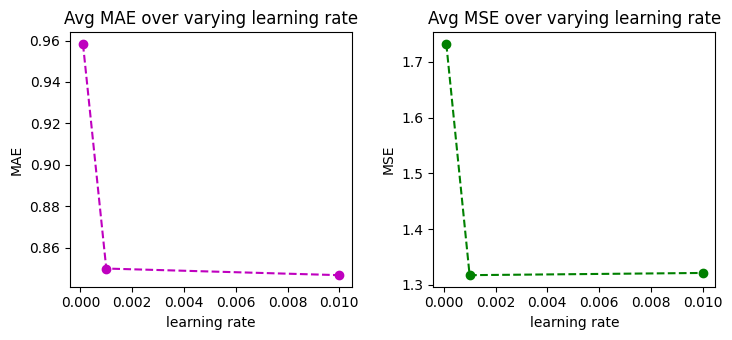

minimum avg mae over learning rates = 0.8467357758208358 at learning rate = 0.01 and mse = 1.321252338789283
minimum avg mse over learning rates = 1.317287691183217 at learning rate = 0.001 and mae = 0.8499268625805789


In [ ]:
avg_mae_list = [0.9583892102254641,0.8499268625805789,0.8467357758208358]
avg_mse_list = [1.7321942511073358,1.317287691183217,1.321252338789283]
learning_rate_list = [0.0001, 0.001, 0.01]
print(f'avg mae over learning rate = [0.0001, 0.001, 0.01]: {avg_mae_list}')
print(f'avg mse over learning rate = [0.0001, 0.001, 0.01]: {avg_mse_list}')
    
plt.rcParams.update({'figure.figsize':(7.5,3.5), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(learning_rate_list, avg_mae_list, 'm--o')
axes[0].set_title('Avg MAE over varying learning rate')
axes[0].set_xlabel('learning rate')
axes[0].set_ylabel('MAE')

axes[1].plot(learning_rate_list, avg_mse_list, 'g--o')
axes[1].set_title('Avg MSE over varying learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

index = 0
min = 100
min_index = 0
for i in avg_mae_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mae over learning rates = {min} at learning rate = {learning_rate_list[min_index]} and mse = {avg_mse_list[min_index]}')

index = 0
min = 100
min_index = 0
for i in avg_mse_list:
  if i<min:
    min = i
    min_index = index
  index+=1
print(f'minimum avg mse over learning rates = {min} at learning rate = {learning_rate_list[min_index]} and mae = {avg_mae_list[min_index]}')

learing rate = 0.001

In [ ]:
if __name__ == "__main__":
    print(sys.path[0])
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    word_latent_dim = 300
    latent_dim = 15
    max_doc_length = 300
    num_filters = 50
    window_size = 5
    v_dim = 50
    learning_rate_list = [0.0001, 0.001, 0.01, 0.1, 1]
    learning_rate = 0.001
    lambda_1 = 0.01 #normally we set from [0.05, 0.01, 0.005, 0.001]
    drop_out = 0.6
    batch_size = 300
    epochs = 240
    avg_mae_list = []
    avg_mse_list = []
    
    # loading data
    firTime = time()
    dataSet = Dataset(max_doc_length, sys.path[0], "dataPreprocessingWordDict.out")
    word_dict, user_reviews, item_reviews, train, valRatings, testRatings = dataSet.word_id_dict, dataSet.userReview_dict, dataSet.itemReview_dict, dataSet.trainMtrx, dataSet.valRatings, dataSet.testRatings
    secTime = time()

    num_users, num_items = train.shape
    print("load data: %.3fs" % (secTime - firTime))
    print(num_users, num_items)
    print(latent_dim)

    #load word embeddings
    word_embedding_mtrx = ini_word_embed(len(word_dict), word_latent_dim)
    # word_embedding_mtrx = word2vec_word_embed(len(word_dict), word_latent_dim,
    #                                           "Directory of pretrained WordEmbedding.out",
    #                                           word_dict)

    print( "shape", word_embedding_mtrx.shape)

    # get train instances
    user_input, item_input, rateings = get_train_instance(train)
    print (len(user_input), len(item_input), len(rateings))

    # get test/val instances
    user_vals, item_vals, user_input_val, item_input_val, rating_input_val = get_test_list(200, valRatings, user_reviews, item_reviews)
    user_tests, item_tests, user_input_test, item_input_test, rating_input_test = get_test_list(200, testRatings, user_reviews, item_reviews)

    #train & eval model
    train_model()


wordId_dict finished
load reviews finished
load data: 8.157s
506 2581
15
shape (19930, 300)
18880 18880 18880
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch0 train time: 18.658s test time: 0.920  loss = 69.261 val_mse = 1.571 mse = 1.523 mae = 1.000
epoch1 train time: 5.709s test time: 0.709  loss = 60.372 val_mse = 1.537 mse = 1.482 mae = 0.923
epoch2 train time: 5.734s test time: 0.714  loss = 44.389 val_mse = 1.513 mse = 1.464 mae = 0.919
epoch3 train time: 5.756s test time: 0.719  loss = 28.626 val_mse = 1.490 mse = 1.447 mae = 0.913
epoch4 train time: 5.822s test time: 0.716  loss = 17.675 val_mse = 1.467 mse = 1.430 mae = 0.906
epoch5 train time: 5.766s test time: 0.715  loss = 10.447 val_mse = 1.443 mse = 1.413 mae = 0.900
epoch6 train time: 5.807s test time: 0.723  loss = 5.946 val_mse = 1.419 mse = 1.396 mae = 0.893
epoch7 train time: 5.837s test time: 0.733  loss = 3.349 val_mse = 1.395 mse = 1.380 